<a href="https://colab.research.google.com/github/mdcctsou/NTHU_2025_DLBOI_HW/blob/main/HW4/hw4_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torch.optim as optims

from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.functional import InterpolationMode

In [2]:
device = torch.device('cuda')
gpu_count = torch.cuda.device_count()

print("Using", gpu_count, "GPUs")
print("CUDA is available:", torch.cuda.is_available())

Using 1 GPUs
CUDA is available: True


In [3]:
# train loop
def train_one_epoch(model, device, criterion, optimizer, train_data_loader):
#def train_one_epoch(model, device, criterion, optimizer, train_loader):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    model.train()

    for batch_idx, (images, labels) in enumerate (train_data_loader):
    #for batch_idx, (images, labels) in enumerate (train_loader):
        images = images.to(device)
        labels = labels.to(device).float()
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels.unsqueeze(1))

        # Calculating Loss
        epoch_loss.append(loss.item())

        # Calculating Metrics
        #predicts = (preds > 0.5).float()
        predicts = (preds > 0.0).float()
        predicts = predicts.view(-1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)

        epoch_acc.append(acc)

        # Backpropagation
        loss.backward()
        optimizer.step()

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100

    return epoch_loss, epoch_acc, total_time

# validation loop
def val_one_epoch(model, device, criterion, val_data_loader, best_acc, save):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    #model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device).float()
            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels.unsqueeze(1))
            epoch_loss.append(loss.item())

            # Calculating Metrics
            #predicts = (preds > 0.5).float()
            predicts = (preds > 0.0).float()
            predicts = predicts.view(-1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100

    # Saving best model
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), f"{save}.pth")

    return epoch_loss, epoch_acc, total_time, best_acc

# evaluate loop (test loop)
def evaluate(model, device, model_path, test_loader):
    try:
        model.load_state_dict(torch.load(model_path))
        print("Model weights loaded successfully.")
    except Exception as e:
        print("Warning: Failed to load model weights. Using randomly initialized weights instead.")
        print(e)

    model.to(device)
    #model.eval()

    test_loss = []
    test_acc = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float()

            # Forward pass
            preds = model(images)

            # Calculating loss
            loss = criterion(preds, labels.unsqueeze(1))
            test_loss.append(loss.item())

            # Calculating accuracy
            #predicts = (preds > 0.5).float()
            predicts = (preds > 0.0).float()
            predicts = predicts.view(-1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            test_acc.append(acc)

    # Overall test results
    avg_test_loss = np.mean(test_loss)
    avg_test_acc = np.mean(test_acc) * 100

    print(f"Test Accuracy: {avg_test_acc:.2f}%")
    print(f"Test Loss: {avg_test_loss:.4f}")

    return avg_test_loss, avg_test_acc

# 資料從 Google Drive 複製到 Colab 虛擬機的本地硬碟 (/content/)。
在 Colab 中訓練的標準作法是，在訓練開始前，先花一次性的時間將資料從 Google Drive 複製到 Colab 虛擬機的本地硬碟 (/content/)。

本地硬碟的 I/O 速度比 Google Drive 快上數百倍。

步驟 1：新增一個程式碼儲存格 (cell)
在您所有的程式碼最前面（或至少在 Block 1 執行前），加入這個儲存格並執行它：

In [5]:
import os
import time

# 1. Google Drive 上的來源路徑
gdrive_data_path = "/content/drive/MyDrive/PhD/DLBOI/Lab3/chest_xray"

# 2. Colab 本地端 VM 的目標路徑
local_data_path = "/content/chest_xray"

print(f"Starting to copy data from {gdrive_data_path} to {local_data_path}...")
start_time = time.time()

# --- 修正：移除了 -q 選項 ---
# -r (recursive) 是必須的，用來複製整個資料夾
!cp -r "{gdrive_data_path}" "{local_data_path}"

end_time = time.time()
print(f"Data copying complete. Time taken: {end_time - start_time:.2f} seconds.")

# 檢查本地檔案
print("\nLocal directory structure (root):")
!ls -l {local_data_path}

print("\nLocal directory structure (train folder check):")
!ls -l {local_data_path}/train

Starting to copy data from /content/drive/MyDrive/PhD/DLBOI/Lab3/chest_xray to /content/chest_xray...
Data copying complete. Time taken: 314.89 seconds.

Local directory structure (root):
total 12
drwx------ 4 root root 4096 Nov 11 09:52 test
drwx------ 4 root root 4096 Nov 11 09:55 train
drwx------ 4 root root 4096 Nov 11 09:50 val

Local directory structure (train folder check):
total 108
drwx------ 2 root root 49152 Nov 11 09:55 NORMAL
drwx------ 2 root root 61440 Nov 11 09:55 PNEUMONIA


# Data Preparation

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
'''
# define folder path for each set
train_path = '/content/drive/MyDrive/PhD/DLBOI/Lab3/chest_xray'
test_path = '/content/drive/MyDrive/PhD/DLBOI/Lab3/chest_xray'
val_path = '/content/drive/MyDrive/PhD/DLBOI/Lab3/chest_xray'
'''
# (Block 1)
# define folder path for each set

# 指向 Colab 本地 VM 的高速硬碟
train_path = '/content/chest_xray/train'
test_path = '/content/chest_xray/test'
val_path = '/content/chest_xray/val'




# define transformation
train_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    #transforms.Grayscale(num_output_channels=1),
    transforms.Grayscale(num_output_channels=3), # 轉換為 3 通道
    transforms.ToTensor(),
])

common_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    #transforms.Grayscale(num_output_channels=1),
    transforms.Grayscale(num_output_channels=3), # 將灰階影像複製成3通道
    transforms.ToTensor(),
])

# create datasets
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_path, transform=common_transform)
val_dataset = datasets.ImageFolder(val_path, transform=common_transform)

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model

In [3]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(256 * 256 * 1, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 1),
    nn.Sigmoid()
)

model.to(device)
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=64, bias=True)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=64, out_features=64, bias=True)
  (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.5, inplace=False)
  (13): Linear(in_features=64, out_features=1, bias=True)
  (14): Sigmoid()
)


In [ ]:
#小補充：每次的初始權重為隨機
#例如檢查第一層的權重：

print(model[1].weight)  # model[1] 是第一個 Linear 層

Parameter containing:
tensor([[ 0.0400,  0.0467,  0.0467,  ...,  0.0361,  0.0190,  0.0093],
        [ 0.0150, -0.0199, -0.0388,  ...,  0.0394,  0.0371,  0.0240],
        [-0.0533, -0.0488, -0.0509,  ..., -0.0524, -0.0474, -0.0469],
        ...,
        [-0.0364, -0.0300, -0.0218,  ..., -0.0465, -0.0484, -0.0485],
        [-0.0519, -0.0534, -0.0481,  ..., -0.0486, -0.0469, -0.0465],
        [ 0.0259,  0.0314,  0.0377,  ..., -0.0457, -0.0450, -0.0437]],
       device='cuda:0', requires_grad=True)


# 列印結構

In [4]:
!pip install torchinfo

In [6]:
from torchinfo import summary
import torch

# 假設的輸入張量形狀：(Batch Size, Channels, Height, Width)
# 您的模型中 nn.Flatten() 在 Linear(256 * 256 * 1, 64) 之前，
# 說明輸入資料在經過 Flatten 前可能是 (Batch Size, 1, 256, 256)
input_size = (64, 1, 256, 256)

# 執行 summary
summary(model, input_size=input_size)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [64, 1]                   --
├─Flatten: 1-1                           [64, 65536]               --
├─Linear: 1-2                            [64, 64]                  4,194,368
├─BatchNorm1d: 1-3                       [64, 64]                  128
├─ReLU: 1-4                              [64, 64]                  --
├─Dropout: 1-5                           [64, 64]                  --
├─Linear: 1-6                            [64, 64]                  4,160
├─BatchNorm1d: 1-7                       [64, 64]                  128
├─ReLU: 1-8                              [64, 64]                  --
├─Dropout: 1-9                           [64, 64]                  --
├─Linear: 1-10                           [64, 64]                  4,160
├─BatchNorm1d: 1-11                      [64, 64]                  128
├─ReLU: 1-12                             [64, 64]                  --

# 模型1帶入模型1 (ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1)

In [7]:
import torchvision.models as models
import torch.nn as nn

from torchvision.models import ShuffleNet_V2_X0_5_Weights
model = models.shufflenet_v2_x0_5(weights=ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1)
#model = models.ShuffleNet_V2_X0_5(weights=ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1)
print(model)

'''
model = models.ShuffleNet_V2_X0_5(pretrained=True)
model

model = models.ShuffleNet_V2_X0_5(weights=None)
model
'''

Downloading: "https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x0.5-f707e7126e.pth


100%|██████████| 5.28M/5.28M [00:00<00:00, 82.6MB/s]

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

'\nmodel = models.ShuffleNet_V2_X0_5(pretrained=True)\nmodel\n\nmodel = models.ShuffleNet_V2_X0_5(weights=None)\nmodel\n'

# 模型1列印結構_模型1

In [8]:
!pip install torchinfo

In [12]:
from torchinfo import summary
import torch

# 假設的輸入張量形狀：(Batch Size, Channels, Height, Width)
# 您的模型中 nn.Flatten() 在 Linear(256 * 256 * 1, 64) 之前，
# 說明輸入資料在經過 Flatten 前可能是 (Batch Size, 1, 256, 256)
input_size = (64, 3, 256, 256)

# 執行 summary
#summary(model, input_size=input_size)
# --- 修改這行 ---
# 我們要求它顯示 'mult_adds' (MAdds)
summary(model,
        input_size=input_size,
        col_names=["input_size", "output_size", "num_params", "mult_adds"], # 加入 "mult_adds"
        verbose=1)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
ShuffleNetV2                             [64, 3, 256, 256]         [64, 1]                   --                        --
├─Sequential: 1-1                        [64, 3, 256, 256]         [64, 24, 128, 128]        --                        --
│    └─Conv2d: 2-1                       [64, 3, 256, 256]         [64, 24, 128, 128]        (648)                     679,477,248
│    └─BatchNorm2d: 2-2                  [64, 24, 128, 128]        [64, 24, 128, 128]        (48)                      3,072
│    └─ReLU: 2-3                         [64, 24, 128, 128]        [64, 24, 128, 128]        --                        --
├─MaxPool2d: 1-2                         [64, 24, 128, 128]        [64, 24, 64, 64]          --                        --
├─Sequential: 1-3                        [64, 24, 64, 64]          [64, 48, 32, 32]          --                        --
│    

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
ShuffleNetV2                             [64, 3, 256, 256]         [64, 1]                   --                        --
├─Sequential: 1-1                        [64, 3, 256, 256]         [64, 24, 128, 128]        --                        --
│    └─Conv2d: 2-1                       [64, 3, 256, 256]         [64, 24, 128, 128]        (648)                     679,477,248
│    └─BatchNorm2d: 2-2                  [64, 24, 128, 128]        [64, 24, 128, 128]        (48)                      3,072
│    └─ReLU: 2-3                         [64, 24, 128, 128]        [64, 24, 128, 128]        --                        --
├─MaxPool2d: 1-2                         [64, 24, 128, 128]        [64, 24, 64, 64]          --                        --
├─Sequential: 1-3                        [64, 24, 64, 64]          [64, 48, 32, 32]          --                        --
│    

# 模型1修改結構_模型1_更換最後一層，使其輸出為2類

In [10]:
# import torch.nn as nn
#import torchvision.models as models
#from torchvision.models import ShuffleNet_V2_X0_5_Weights

# 1. 載入預訓練模型
#model = models.shufflenet_v2_x0_5(weights=ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1)

# 2. 獲取最後一個全連接層（fc 層）的輸入特徵數量 (In Features)
# 這是 ShuffleNet V2 模型的標準做法
num_ftrs = model.fc.in_features

# 3. 替換最後一個全連接層 (Linear Layer)
# 將輸出類別數 (out_features) 設定為 2
#model.fc = nn.Linear(num_ftrs, 2)
# 只需要 1 個輸出 (logit) for BCE loss
model.fc = nn.Linear(num_ftrs, 1)

# 可選：將模型移動到 GPU (如果您有設定 device 的話)
model.to(device)

# 4. 檢查修改後的模型結構
print(model.fc)

Linear(in_features=1024, out_features=1, bias=True)


# 模型1Loop for all layer fine tyning

In [ ]:
# hyperparameter
lr = 0.01
weight_decay = 0.001
optimizer = optims.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
lr_scheduler = optims.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='max')
epochs = 10
#optimizer = optims.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
#criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
# 這是專門用來處理 "logits" 的 BCELoss
criterion = nn.BCEWithLogitsLoss()

# save checkpoint
save = 'model'

# 模型1if 權重凍結 (Weight Freezing)
在進行遷移學習時，只訓練新的分類器
這會凍結所有預訓練的捲積層權重，只訓練您新替換的 model.fc 層。這樣可以防止預訓練權重被您的小型資料集破壞。

In [11]:
# 凍結所有模型參數
for param in model.parameters():
    param.requires_grad = False

# 只有新替換的分類器層的參數需要訓練
for param in model.fc.parameters():
    param.requires_grad = True

# hyperparameter
lr = 0.01
weight_decay = 0.001
# 修正：只將 fc 層的參數傳遞給 optimizer
optimizer = optims.Adam(model.fc.parameters(), lr=lr, weight_decay = weight_decay)
#optimizer = optims.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
lr_scheduler = optims.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='max')
epochs = 10
#criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
# 這是專門用來處理 "logits" 的 BCELoss
criterion = nn.BCEWithLogitsLoss()

# save checkpoint
save = 'model'

# 模型2帶入模型2 (EfficientNet_B2_Weights.IMAGENET1K_V1)

In [7]:
import torchvision.models as models
import torch.nn as nn

from torchvision.models import EfficientNet_B2_Weights
model = models.efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1)
print(model)

#from torchvision.models import ShuffleNet_V2_X0_5_Weights
#model = models.shufflenet_v2_x0_5(weights=ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1)
#model = models.ShuffleNet_V2_X0_5(weights=ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1)

'''
model = models.ShuffleNet_V2_X0_5(pretrained=True)
model

model = models.ShuffleNet_V2_X0_5(weights=None)
model
'''

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:00<00:00, 179MB/s]

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

'\nmodel = models.ShuffleNet_V2_X0_5(pretrained=True)\nmodel\n\nmodel = models.ShuffleNet_V2_X0_5(weights=None)\nmodel\n'

# 模型2列印結構

In [8]:
!pip install torchinfo

In [13]:
from torchinfo import summary
import torch

# 假設的輸入張量形狀：(Batch Size, Channels, Height, Width)
# 您的模型中 nn.Flatten() 在 Linear(256 * 256 * 1, 64) 之前，
# 說明輸入資料在經過 Flatten 前可能是 (Batch Size, 1, 256, 256)
input_size = (64, 3, 256, 256)

# 執行 summary
#summary(model, input_size=input_size)
# --- 修改這行 ---
# 我們要求它顯示 'mult_adds' (MAdds)
summary(model,
        input_size=input_size,
        col_names=["input_size", "output_size", "num_params", "mult_adds"], # 加入 "mult_adds"
        verbose=1)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Mult-Adds
EfficientNet                                            [64, 3, 256, 256]         [64, 1]                   --                        --
├─Sequential: 1-1                                       [64, 3, 256, 256]         [64, 1408, 8, 8]          --                        --
│    └─Conv2dNormActivation: 2-1                        [64, 3, 256, 256]         [64, 32, 128, 128]        --                        --
│    │    └─Conv2d: 3-1                                 [64, 3, 256, 256]         [64, 32, 128, 128]        (864)                     905,969,664
│    │    └─BatchNorm2d: 3-2                            [64, 32, 128, 128]        [64, 32, 128, 128]        (64)                      4,096
│    │    └─SiLU: 3-3                                   [64, 32, 128, 128]        [64, 32, 128, 128]        --                        --
│    └─Sequential: 2-2

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Mult-Adds
EfficientNet                                            [64, 3, 256, 256]         [64, 1]                   --                        --
├─Sequential: 1-1                                       [64, 3, 256, 256]         [64, 1408, 8, 8]          --                        --
│    └─Conv2dNormActivation: 2-1                        [64, 3, 256, 256]         [64, 32, 128, 128]        --                        --
│    │    └─Conv2d: 3-1                                 [64, 3, 256, 256]         [64, 32, 128, 128]        (864)                     905,969,664
│    │    └─BatchNorm2d: 3-2                            [64, 32, 128, 128]        [64, 32, 128, 128]        (64)                      4,096
│    │    └─SiLU: 3-3                                   [64, 32, 128, 128]        [64, 32, 128, 128]        --                        --
│    └─Sequential: 2-2

# 模型2修改結構_更換最後一層，使其輸出為2類

In [10]:
# import torch.nn as nn
#import torchvision.models as models
#from torchvision.models import ShuffleNet_V2_X0_5_Weights

# 1. 載入預訓練模型
#model = models.shufflenet_v2_x0_5(weights=ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1)

"""
# 示範程式碼
from torchvision.models import efficientnet_b2
from torchvision.models import EfficientNet_B2_Weights
import torch.nn as nn

model = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1)
"""


# 1. 存取 'classifier' 容器中的最後一個元素 (即 Linear 層)
final_linear_layer = model.classifier[-1]
num_ftrs = final_linear_layer.in_features

# 2. 替換最終層 (從 1000 類換成 1 類)
# 直接替換 nn.Sequential 容器中的最後一個元素
model.classifier[-1] = nn.Linear(num_ftrs, 1)

# Fix: Clear GPU memory before attempting to move the model
import torch
import gc
torch.cuda.empty_cache()
gc.collect()

# 3可選：將模型移動到 GPU (如果您有設定 device 的話)
model.to(device)

# 4. 檢查修改後的模型結構
print(model.classifier[-1])

'''
# 2. 獲取最後一個全連接層（fc 層）的輸入特徵數量 (In Features)
# 這是 ShuffleNet V2 模型的標準做法
num_ftrs = model.fc.in_features

# 3. 替換最後一個全連接層 (Linear Layer)
# 將輸出類別數 (out_features) 設定為 2
#model.fc = nn.Linear(num_ftrs, 2)
# 只需要 1 個輸出 (logit) for BCE loss
model.fc = nn.Linear(num_ftrs, 1)

# 可選：將模型移動到 GPU (如果您有設定 device 的話)
model.to(device)

# 4. 檢查修改後的模型結構
print(model.fc)
'''

Linear(in_features=1408, out_features=1, bias=True)


'\n# 2. 獲取最後一個全連接層（fc 層）的輸入特徵數量 (In Features)\n# 這是 ShuffleNet V2 模型的標準做法\nnum_ftrs = model.fc.in_features\n\n# 3. 替換最後一個全連接層 (Linear Layer)\n# 將輸出類別數 (out_features) 設定為 2\n#model.fc = nn.Linear(num_ftrs, 2)\n# 只需要 1 個輸出 (logit) for BCE loss\nmodel.fc = nn.Linear(num_ftrs, 1)\n\n# 可選：將模型移動到 GPU (如果您有設定 device 的話)\nmodel.to(device)\n\n# 4. 檢查修改後的模型結構\nprint(model.fc)\n'

# 模型2Loop for all layer fine tyning

In [ ]:
# hyperparameter
lr = 0.01
weight_decay = 0.001
optimizer = optims.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
lr_scheduler = optims.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='max')
epochs = 10
#optimizer = optims.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
#criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
# 這是專門用來處理 "logits" 的 BCELoss
criterion = nn.BCEWithLogitsLoss()

# save checkpoint
save = 'model'

# 模型2if 權重凍結 (Weight Freezing)
在進行遷移學習時，只訓練新的分類器
這會凍結所有預訓練的捲積層權重，只訓練您新替換的 model.fc 層。這樣可以防止預訓練權重被您的小型資料集破壞。

In [12]:
# 凍結所有模型參數
for param in model.parameters():
    param.requires_grad = False

# 只有新替換的分類器層的參數需要訓練
for param in model.classifier[-1].parameters():
    param.requires_grad = True

# hyperparameter
lr = 0.01
weight_decay = 0.001
# 修正：只將 fc 層的參數傳遞給 optimizer
optimizer = optims.Adam(model.classifier[-1].parameters(), lr=lr, weight_decay = weight_decay)
#optimizer = optims.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
lr_scheduler = optims.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='max')
epochs = 10
#criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
# 這是專門用來處理 "logits" 的 BCELoss
criterion = nn.BCEWithLogitsLoss()

# save checkpoint
save = 'model'

# XX Loop

In [ ]:
# hyperparameter
lr = 0.01
weight_decay = 0.001
optimizer = optims.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
lr_scheduler = optims.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='max')
epochs = 10
#optimizer = optims.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
criterion = nn.BCELoss()

# save checkpoint
save = 'model'

# Train

In [14]:
#import gc
#torch.cuda.empty_cache()
#gc.collect()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_acc = 0.0
output_list = []

for epoch in range(epochs):
    train_loss, train_acc, train_time = train_one_epoch(model, device, criterion, optimizer, train_loader)
    val_loss, val_acc, val_time, best_acc = val_one_epoch(model, device, criterion, val_loader, best_acc, save)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    total_time = train_time + val_time
    output_str = f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - train_acc: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_acc: {val_acc:.2f}% - time: {total_time:.2f}s"
    output_list.append(output_str)
    print(output_str)
    lr_scheduler.step(val_acc)

Epoch 1/10 - loss: 0.2583 - train_acc: 88.64% - val_loss: 0.2284 - val_acc: 81.25% - time: 65.02s
Epoch 2/10 - loss: 0.1618 - train_acc: 94.05% - val_loss: 0.3662 - val_acc: 87.50% - time: 62.75s
Epoch 3/10 - loss: 0.1646 - train_acc: 93.70% - val_loss: 0.5867 - val_acc: 68.75% - time: 62.44s
Epoch 4/10 - loss: 0.1464 - train_acc: 94.64% - val_loss: 0.3421 - val_acc: 81.25% - time: 61.75s
Epoch 5/10 - loss: 0.1585 - train_acc: 94.54% - val_loss: 0.0998 - val_acc: 93.75% - time: 62.72s
Epoch 6/10 - loss: 0.1308 - train_acc: 95.19% - val_loss: 0.1678 - val_acc: 93.75% - time: 62.40s
Epoch 7/10 - loss: 0.1424 - train_acc: 94.69% - val_loss: 0.3165 - val_acc: 75.00% - time: 62.37s
Epoch 8/10 - loss: 0.1148 - train_acc: 95.68% - val_loss: 0.3150 - val_acc: 93.75% - time: 61.12s
Epoch 9/10 - loss: 0.1725 - train_acc: 94.00% - val_loss: 0.1357 - val_acc: 93.75% - time: 62.40s
Epoch 10/10 - loss: 0.1617 - train_acc: 94.25% - val_loss: 0.3249 - val_acc: 93.75% - time: 62.48s


# Graph

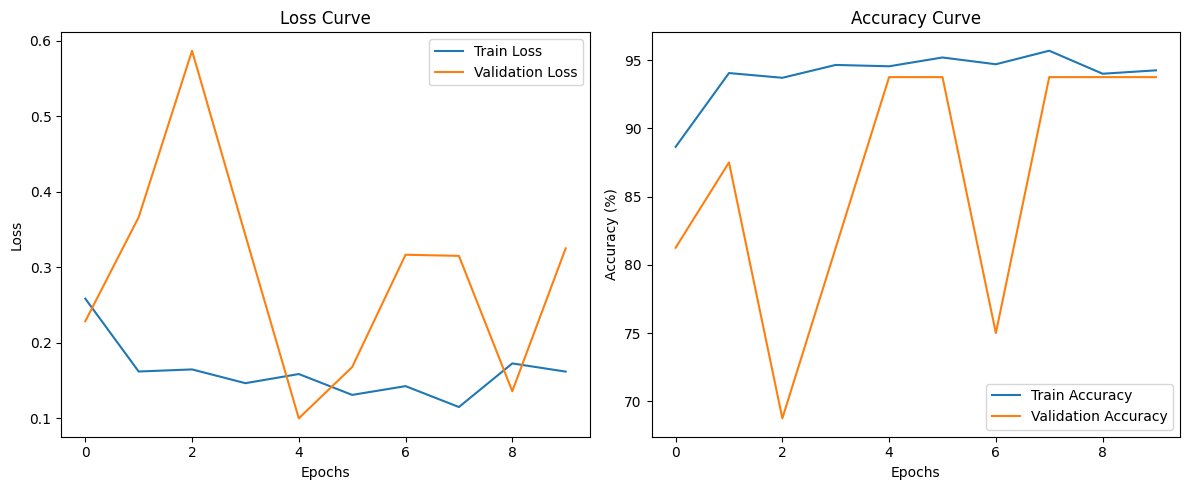

In [15]:
plt.figure(figsize=(12, 5))

# loss graph
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy graph
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# show
plt.tight_layout()
plt.show()

# Evaluate

In [16]:
model_path = 'model.pth'
avg_test_loss, avg_test_acc = evaluate(model, device, model_path, test_loader)

Model weights loaded successfully.
Test Accuracy: 52.19%
Test Loss: 1.3310


## 獨立執行 LR Finder

安裝與引入

In [ ]:
# 只需要執行一次的安裝
!pip install torch-lr-finder

# 引入 LRFinder
from torch_lr_finder import LRFinder

/usr/local/lib/python3.12/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


執行 LR Finder

--- Starting LR Range Test using LRFinder (FINAL FIX) ---


  0%|          | 0/32 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.62E-02


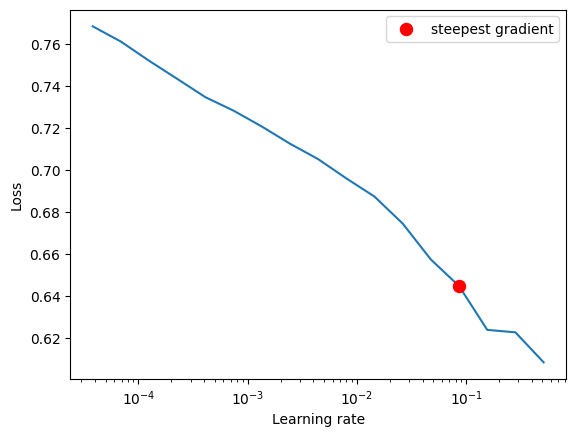

AttributeError: 'LRFinder' object has no attribute 'suggestions'

In [ ]:
# -----------------------------------------------------------------------
# LR Finder / LR Range Test - 獨立執行 Cell (最終修正)
# -----------------------------------------------------------------------
print("--- Starting LR Range Test using LRFinder (FINAL FIX) ---")
# 最終修正步驟：定義一個包裝過的損失函數，確保 target 為 float
class WrappedBCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCELoss()

    def forward(self, input, target):
        # 1. 將 target 的資料類型轉換為 float (必須!)
        target = target.float()

        # 2. 確保 target 擁有和 input 相同的 [B, 1] 尺寸 (維度修正)
        if target.dim() == 1:
            target = target.unsqueeze(1)

        return self.bce(input, target)

# 1. 定義一個與您原始程式碼中模型結構完全相同的模型 (用於測試)
lr_finder_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(256 * 256 * 1, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 1),
    nn.Sigmoid()
).to(device)

# 2. 建立新的優化器和損失函數實例
lr_finder_optimizer = optims.Adam(lr_finder_model.parameters(), lr=1e-7, weight_decay=0.0)
lr_finder_criterion = WrappedBCELoss() # 使用修正後的損失函數

# 3. 初始化 LRFinder
lr_finder = LRFinder(
    lr_finder_model,
    lr_finder_optimizer,
    lr_finder_criterion,
    device=device
)

# 4. 執行學習率搜索
lr_finder.range_test(
    train_loader,
    start_lr=1e-7,
    end_lr=10,
    num_iter=len(train_loader),
    step_mode="exp"
)

# 5. 繪製結果並建議最佳學習率
lr_finder.plot(log_lr=True, suggest_lr=True)

# 6. 取得建議值
suggested_lr = lr_finder.suggestions()[1]

print("="*60)
print(f"✅ LRFinder 建議的最佳初始學習率為: {suggested_lr:.5e}")
print("請觀察圖表，選擇損失開始急劇下降點的 LR (通常是建議值或其左側一個數量級)。")
print("="*60)

# 7. 重置模型和優化器
lr_finder.reset()

In [ ]:
# 1. 掛載 Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. 指定你的 notebook 路徑（請改成你實際檔案路徑）
uploaded_filename = '/content/drive/MyDrive/Colab Notebooks/20251006_DLBOI_HW3.ipynb'  # ← 改成你的完整路徑

# 3. 讀取 notebook JSON，清除 metadata.widgets
import json

with open(uploaded_filename, 'r', encoding='utf-8') as f:
    data = json.load(f)

if 'widgets' in data.get('metadata', {}):
    del data['metadata']['widgets']
    print("✅ 已成功移除 metadata.widgets")
else:
    print("ℹ️ metadata.widgets 不存在，不需要移除")

# 4. 儲存成新檔案（在同一個資料夾，名稱加上 _cleaned）
cleaned_filename = uploaded_filename.replace('.ipynb', '_cleaned.ipynb')
with open(cleaned_filename, 'w', encoding='utf-8') as f:
    json.dump(data, f, indent=2)

print(f"📁 清理後檔案已儲存：{cleaned_filename}")

# 5. 下載清理後的 notebook
from google.colab import files
files.download(cleaned_filename)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 已成功移除 metadata.widgets
📁 清理後檔案已儲存：/content/drive/MyDrive/Colab Notebooks/20251006_DLBOI_HW3_cleaned.ipynb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>